# Group 5
## Team members:
- Jianting Liu(8950907)
- David (8999846) 
- Marieth (9016702)


## Use case
 This analysis examines the stationarity of deseasonalized apartment unit prices in Canada from 2005 to 2022. Using the Augmented Dickey-Fuller test, we investigate whether the deseasonalized time series exhibits constant statistical properties over time. Stationarity is crucial for many time series modeling techniques and can provide insights into the long-term behavior of housing prices. If the deseasonalized data is stationary, it suggests that any shocks to the housing market are temporary, and prices tend to revert to a long-term mean. Non-stationarity, conversely, might indicate persistent trends or structural changes in the market.

C:\Users\Akindele Awe David\AppData\Local\Temp\ipykernel_13416\946913318.py:31: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  self.income_data['Median income'] = self.income_data['Median income'].str.replace('$', '').str.replace(',', '').astype(float)


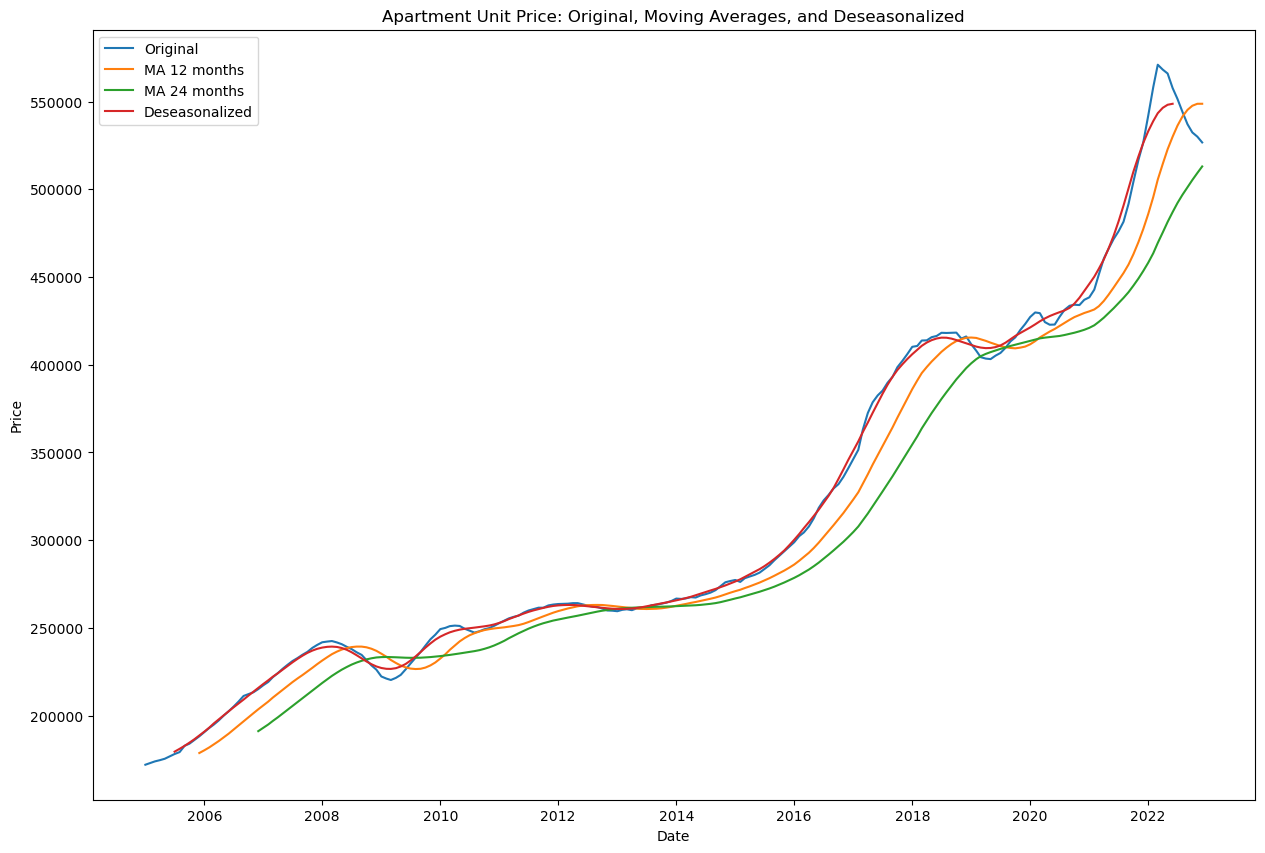

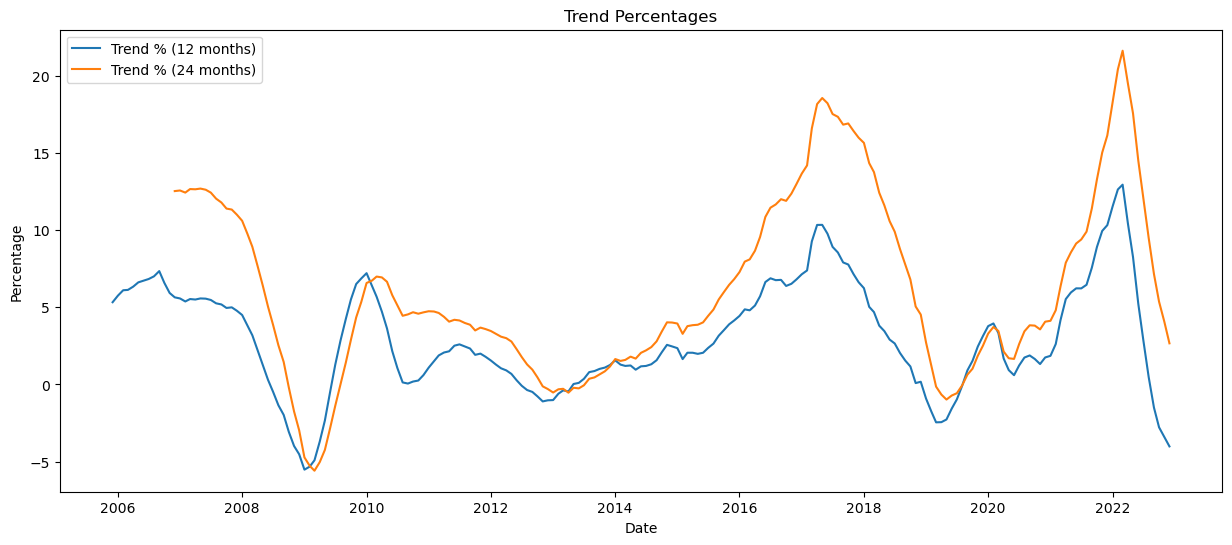


Technical Analysis of Time Series Pattern:
Analysis indicates a multiplicative trend pattern: 
The variance of the 24-month ratio (0.0033) exceeds the 12-month ratio variance (0.0012). 
This suggests seasonal fluctuations that vary proportionally with the trend level, characteristic of a multiplicative 
time series.

Hypothesis Formulation:
Null Hypothesis (H0): The deseasonalized time series is not likely stationary.
Alternative Hypothesis (H1): The deseasonalized time series is  likely stationary.

Augmented Dickey-Fuller Test Results:
ADF Statistic: 0.8551504455494107
p-value: 0.9924762057486053
Critical Values:
   1%: -3.465620397124192
   5%: -2.8770397560752436
   10%: -2.5750324547306476

Conclusion: We fail to reject the null hypothesis.
There is not enough evidence to conclude that the deseasonalized time series is stationary.


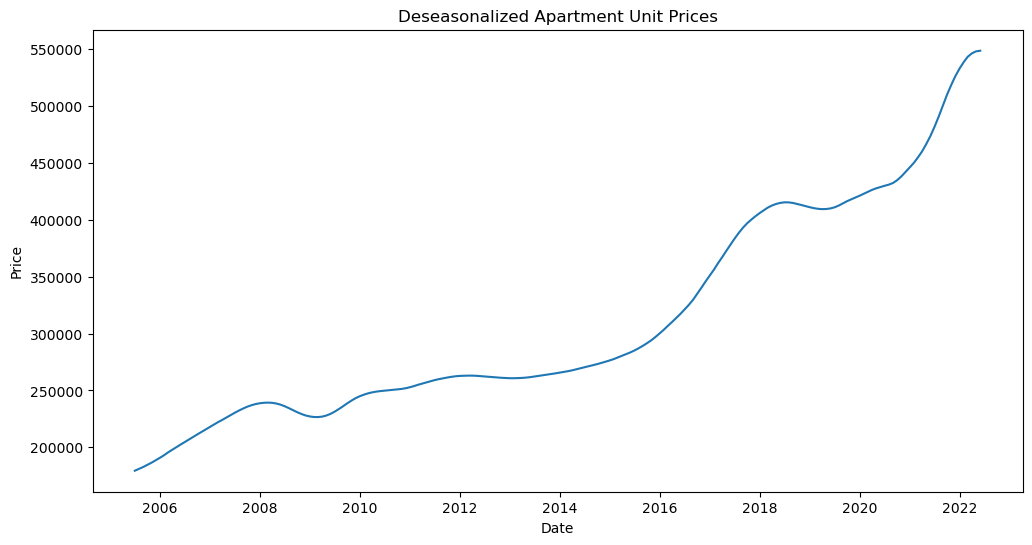

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import spearmanr
import statsmodels.tsa.seasonal as tsa
from statsmodels.tsa.stattools import adfuller  

class IncomeDataProcessor:
    """
    A class to process income and house price data.
    """

    def __init__(self, income_data_path, original_data_path):
        """
        Initializes the class with the given data paths.

        Args:
            income_data_path (str): Path to the income data CSV file.
            original_data_path (str): Path to the original data Excel file.
        """
        self.income_data = pd.read_csv(income_data_path)
        self.original_data = pd.read_excel(original_data_path)

    def clean_data(self):
        """
        Cleans the income data by removing currency symbols and converting to numeric.
        """
        self.income_data['Median income'] = self.income_data['Median income'].str.replace('$', '').str.replace(',', '').astype(float)

    def convert_to_monthly(self):
        """
        Converts annual income to monthly income and creates a new DataFrame.
        """
        # Create a list to store new data
        new_rows = []
        
        # Loop for income data
        for index, row in self.income_data.iterrows():
            year = row["Reference year"]
            median_income = row["Median income"] / 12  # Convert to monthly income
            
            for month in range(1, 13):
                date_str = f"{year}-{month:02d}-01"
                date = pd.to_datetime(date_str, format='%Y-%m-%d')
                
                new_row = {
                    "Date": date,
                    "Median income": median_income,
                    "Count of families": row["Count of families"],
                    "Family type": row["Family type"],
                    "Geography": row["Geography"],
                    "Selected income concept": row["Selected income concept"]
                }
                new_rows.append(new_row)
        
        # Create new DataFrame and store it as monthly_data
        self.monthly_data = pd.DataFrame(new_rows)
        
        return self.monthly_data

    def merge_data(self):
        """
        Merges the income data with the original data based on the 'Date' column.
        """
        self.monthly_data['Date'] = pd.to_datetime(self.monthly_data['Date'], format='%Y-%m-%d')
        self.merged_data = pd.merge(self.original_data, self.monthly_data[['Date', 'Median income']], on='Date', how='left')
        # Filter data from 2005 to 2022
        self.merged_data = self.merged_data[(self.merged_data['Date'].dt.year >= 2005) & 
                                           (self.merged_data['Date'].dt.year <= 2022)]

    def exploratory_data_analysis(self):
        """
        Performs exploratory data analysis, including:
            - Visualizing the relationship between income and house price
            - Calculating moving averages and trend percentages
            - Deseasonalizing time series
            - Identifying additive or multiplicative trend
        """
        # Set Date as index for time series analysis
        self.merged_data.set_index('Date', inplace=True)

        # Calculate Moving Averages
        windows = [12, 24]  # 12 months (1 year) and 24 months (2 years)
        for window in windows:
            col_name = f'Moving Average ({window} months)'
            self.merged_data[col_name] = self.merged_data['Apartment_unit'].rolling(window=window).mean()

        # Calculate Trend Percentages
        for window in windows:
            ma_col = f'Moving Average ({window} months)'
            trend_col = f'Trend Percentage ({window} months)'
            self.merged_data[trend_col] = ((self.merged_data['Apartment_unit'] - self.merged_data[ma_col]) / 
                                          self.merged_data[ma_col] * 100)

        # Deseasonalize the time series
        decomposition = tsa.seasonal_decompose(self.merged_data['Apartment_unit'], model='additive', period=12)
        self.merged_data['Deseasonalized'] = decomposition.trend

        # Plot results
        plt.figure(figsize=(15, 10))
        plt.plot(self.merged_data.index, self.merged_data['Apartment_unit'], label='Original')
        for window in windows:
            plt.plot(self.merged_data.index, 
                    self.merged_data[f'Moving Average ({window} months)'], 
                    label=f'MA {window} months')
        plt.plot(self.merged_data.index, self.merged_data['Deseasonalized'], label='Deseasonalized')
        plt.title('Apartment Unit Price: Original, Moving Averages, and Deseasonalized')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        # Plot Trend Percentages
        plt.figure(figsize=(15, 6))
        for window in windows:
            plt.plot(self.merged_data.index, 
                    self.merged_data[f'Trend Percentage ({window} months)'], 
                    label=f'Trend % ({window} months)')
        plt.title('Trend Percentages')
        plt.xlabel('Date')
        plt.ylabel('Percentage')
        plt.legend()
        plt.show()

        # Identify Additive or Multiplicative Trend
        variances = {}
        for window in windows:
            # Calculate ratio of original to moving average
            ratio_col = f'Ratio ({window} months)'
            self.merged_data[ratio_col] = (self.merged_data['Apartment_unit'] / 
                                          self.merged_data[f'Moving Average ({window} months)'])
            variances[window] = self.merged_data[ratio_col].var()

        # Technical statement about trend type
        print("\nTechnical Analysis of Time Series Pattern:")
        if variances[12] > variances[24]:
            print("Analysis indicates an additive trend pattern: The variance of the 12-month ratio "
                  f"({variances[12]:.4f}) exceeds the 24-month ratio variance ({variances[24]:.4f}). "
                  "This suggests relatively consistent seasonal fluctuations independent of the trend level, "
                  "characteristic of an additive time series.")
        elif variances[12] < variances[24]:
            print("Analysis indicates a multiplicative trend pattern: \nThe variance of the 24-month ratio "
                  f"({variances[24]:.4f}) exceeds the 12-month ratio variance ({variances[12]:.4f}). \n"
                  "This suggests seasonal fluctuations that vary proportionally with the trend level, "
                  "characteristic of a multiplicative \ntime series.")
        else:
            print("The analysis is inconclusive: The variances of the 12-month and 24-month ratios are similar "
                  f"({variances[12]:.4f} vs {variances[24]:.4f}). Additional analysis methods may be needed "
                  "to definitively characterize the trend pattern.")
    def test_stationarity(self):
        """
        Performs the Augmented Dickey-Fuller test on the deseasonalized data to check for stationarity.
        """

        # Define the hypotheses
        print("")
        print("Hypothesis Formulation:")
        print("Null Hypothesis (H0): The deseasonalized time series is not likely stationary.")
        print("Alternative Hypothesis (H1): The deseasonalized time series is  likely stationary.")

        # Perform ADF test
        result = adfuller(self.merged_data['Deseasonalized'].dropna())
        
        # Extract and print the test statistics
        adf_statistic = result[0]
        p_value = result[1]
        critical_values = result[4]
        
        print("\nAugmented Dickey-Fuller Test Results:")
        print(f"ADF Statistic: {adf_statistic}")
        print(f"p-value: {p_value}")
        print("Critical Values:")
        for key, value in critical_values.items():
            print(f"   {key}: {value}")
        
        # Interpret the results
        if p_value <= 0.05:
            print("\nConclusion: We reject the null hypothesis.")
            print("The deseasonalized time series is likely stationary.")
        else:
            print("\nConclusion: We fail to reject the null hypothesis.")
            print("There is not enough evidence to conclude that the deseasonalized time series is stationary.")
        
        # Visualize the deseasonalized data
        plt.figure(figsize=(12, 6))
        plt.plot(self.merged_data.index, self.merged_data['Deseasonalized'])
        plt.title('Deseasonalized Apartment Unit Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.show()
    def save_data(self, output_path):
        """
        Saves the merged data to a CSV file.
        """
        self.merged_data.to_csv(output_path)

# Example usage
processor = IncomeDataProcessor('incomedata.csv', 'News_release_chart_data_August_2024.xlsx')
processor.clean_data()
processor.convert_to_monthly()
processor.merge_data()
processor.exploratory_data_analysis()
processor.test_stationarity() 
#processor.save_data('mergeddata.csv')

## Summary for trend percentage

Here's a simpler summary:

Canadian apartment prices have been on a rollercoaster ride over the last 15+ years! The market has seen big ups and downs, with major price jumps in 2016 and 2021, and some drops in 2009 and 2018. The biggest changes happened after 2016 - prices went crazy high in 2020-2021, going up by over 20%! While prices go up and down every 5-7 years or so, they generally keep climbing higher over time. The housing market crash in 2008-2009 caused a big dip, but prices bounced back pretty quickly. Overall, despite all the zigzags, apartment prices in Canada have mostly been heading up.